In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-11-03 19:20:22.704904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-03 19:20:22.733842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-03 19:20:23.378465: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("Enabled memory growth for GPUs")
    except Exception as e:
        print("Could not set memory growth:", e)

Enabled memory growth for GPUs


In [3]:
BASE_DIR = "/home/amit/code_only/code/new/potato_disease_classifier/data"
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 12
CHANNELS = 3
NUM_CLASSES = 4
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
train_dir = os.path.join(BASE_DIR, "Train")
val_dir   = os.path.join(BASE_DIR, "Val")
test_dir  = os.path.join(BASE_DIR, "Test")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 5702 files belonging to 3 classes.


I0000 00:00:1762177823.866585    5360 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 1282 files belonging to 3 classes.
Found 160 files belonging to 4 classes.
Classes: ['Early Blight', 'Healthy', 'Late Blight']


In [5]:
train_ds = train_ds.shuffle(buffer_size=2000).prefetch(buffer_size=1)
val_ds   = val_ds.prefetch(buffer_size=1)
test_ds  = test_ds.prefetch(buffer_size=1)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
def augment(x, y):
    return x, y

In [7]:
input_shape = IMAGE_SIZE + (CHANNELS,)

augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

model = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
], name="apple_disease_cnn")

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "apple_disease_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,268 (1012.77 KB)

 Trainable params: 258,564 (1010.02 KB)

 Non-trainable params: 704 (2.75 KB)

In [8]:
checkpoint_dir = "../models"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "best_model.keras")

cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]


In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb,
    verbose=1
)

Epoch 1/50


2025-11-03 19:20:28.875005: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8746 - loss: 0.3674 
Epoch 1: val_loss improved from None to 23.56473, saving model to ../models/best_model.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9156 - loss: 0.2472 - val_accuracy: 0.3401 - val_loss: 23.5647 - learning_rate: 0.0010
Epoch 2/50
475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9409 - loss: 0.1643 
Epoch 2: val_loss improved from 23.56473 to 0.31900, saving model to ../models/best_model.keras
476/476 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.9434 - loss: 0.1604 - val_accuracy: 0.9002 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9530 - loss: 0.1376 
Epoch 3: val_loss did not improve from 0.31900
476/476 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.9553 - loss: 0.1251 - val_accuracy: 0.4914 - val_loss: 3.1120 - learning_rate: 0.0010
Epoch 4/50
475/476 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9562 - loss: 0

In [10]:
scores = model.evaluate(test_ds, verbose=1)
print("Test loss:", scores[0], "Test accuracy:", scores[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7750 - loss: 1.5328
Test loss: 1.532846450805664 Test accuracy: 0.7749999761581421


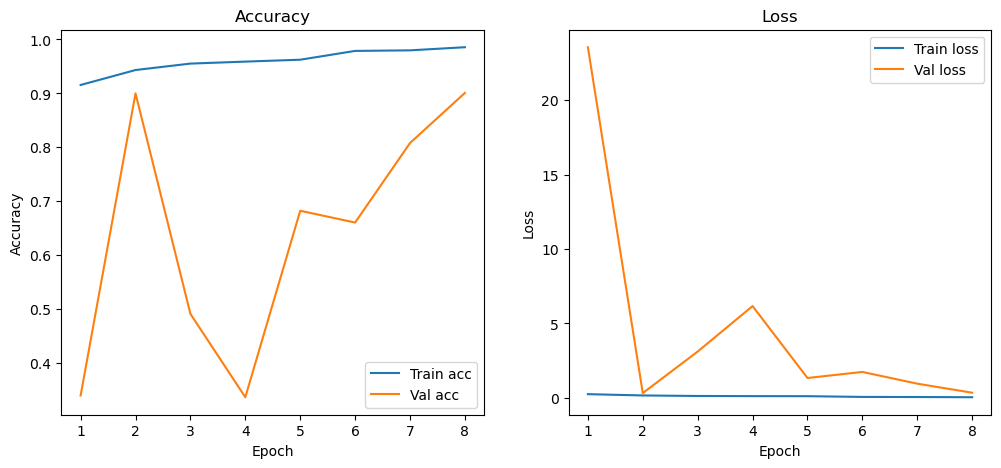

In [11]:
epochs_ran = len(history.history['loss'])
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs_ran+1), history.history['accuracy'], label='Train acc')
plt.plot(range(1, epochs_ran+1), history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(1, epochs_ran+1), history.history['loss'], label='Train loss')
plt.plot(range(1, epochs_ran+1), history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.show()

In [12]:
def predict_image(model, image_tensor):
    img = tf.cast(image_tensor, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.expand_dims(img, 0)  # batch of 1
    preds = model.predict(img)
    idx = int(np.argmax(preds[0]))
    return class_names[idx], float(np.max(preds[0]) * 100.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2025-11-03 19:23:47.282971: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


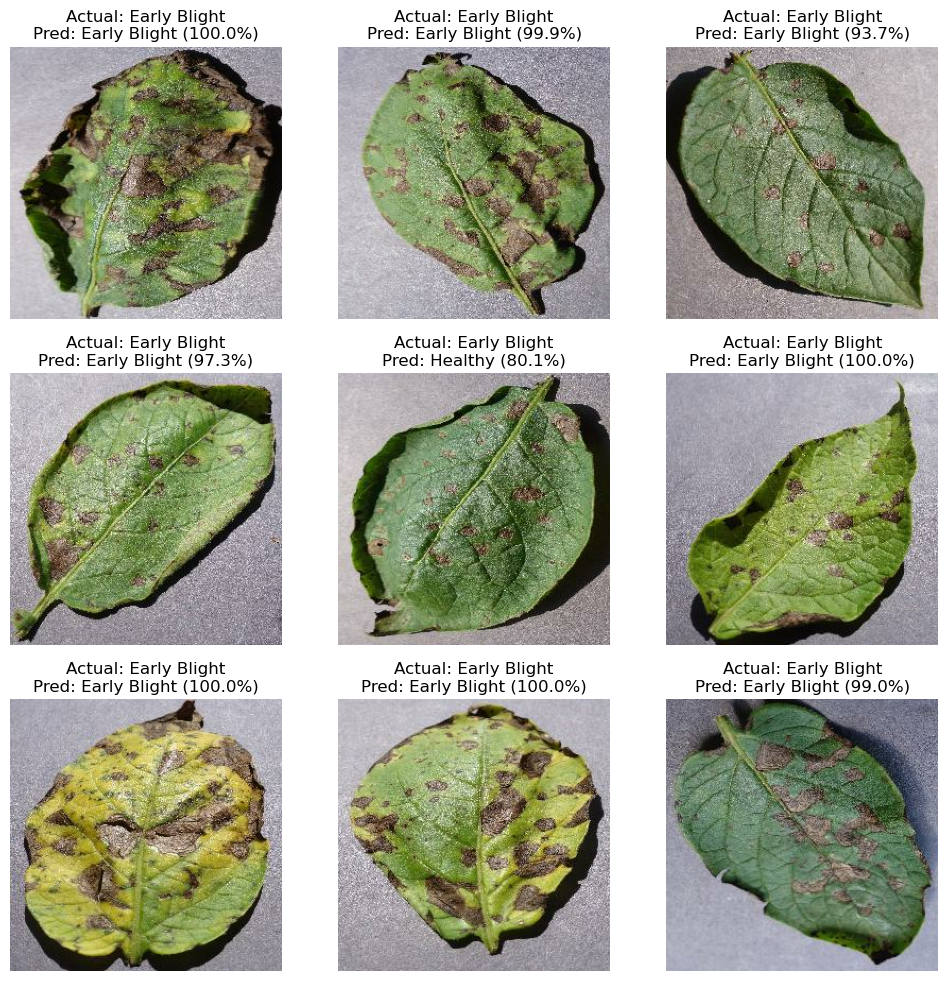

In [13]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy().astype('uint8')
        actual = class_names[int(labels[i])]
        pred_name, conf = predict_image(model, img)
        plt.imshow(img)
        plt.title(f"Actual: {actual}\nPred: {pred_name} ({conf:.1f}%)")
        plt.axis('off')
plt.show()

In [14]:
# def safe_save_model(m, out_dir="../models"):
#     os.makedirs(out_dir, exist_ok=True)
#     existing = [d for d in os.listdir(out_dir) if os.path.isdir(os.path.join(out_dir, d))]
#     version = (max([int(v) for v in existing if v.isdigit()] + [0]) + 1)
#     save_path = os.path.join(out_dir, f"{version}.keras")
#     m.save(save_path)
#     print("✅ Saved model to", save_path)

# safe_save_model(model, checkpoint_dir)

In [15]:
def safe_save_model(model, out_dir="../models"):
    """
    Save a Keras model to `out_dir` with an incrementing version number.
    Example: 1.keras, 2.keras, 3.keras, ...
    """
    os.makedirs(out_dir, exist_ok=True)

    # Get all existing .keras files
    existing_files = [
        f for f in os.listdir(out_dir)
        if f.endswith(".keras") and f[:-6].isdigit()
    ]

    # Determine next version number
    if existing_files:
        versions = [int(f[:-6]) for f in existing_files]
        next_version = max(versions) + 1
    else:
        next_version = 1

    # Construct save path
    save_path = os.path.join(out_dir, f"{next_version}.keras")

    # Save the model
    model.save(save_path)
    print(f"✅ Saved model as: {save_path}")

    return save_path

safe_save_model(model)

✅ Saved model as: ../models/2.keras


'../models/2.keras'